The class Logistic_regression was built from scratch. In the following, its performance and accuracy was examined and compared with Sk-learn LogisticRegression. Finally, the path of batch gradient descent and stochastic gradient descent was visualised on a contour map.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from scipy.stats import linregress
import logging
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from IPython.display import Image, display


logging.basicConfig(filename='logistic_regression.log',level=logging.DEBUG)


class Logistic_regression():
        
    def __init__(self, X, y, alpha, lamb, num_iter):
        self.X = X
        self.y = y
        self.alpha = alpha
        self.lamb = lamb
        self.num_iter =num_iter
        self.loss_vs_iter = {}
        self.thetas = None
        
        
    def sigmoid(self, z = np.array):
        h = 1/(1+np.exp(-z))
        return h
        
    def predict(self, x_test):
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis = 1)        
        y_predict = np.round(self.sigmoid(np.dot(self.thetas, x_test.T)).flatten())
        
        
        return y_predict
    def score(self, X, y):
        y_predict = self.predict(X)
        accuracy = np.sum((y_predict.flatten() == y.flatten()))/len(y_predict)        
        return accuracy
        
    def SGD(self):
        '''
        1. add a bias feature which is always equal to 1.
        2. randomly shuffle the dataset (X and y)
        3. set all thetas as 0 (number of theta is the number of features + 1 (bias))        
        4. iteratively, compute the gradient for each sample size.
        5. update all thetas after each computation.
        6. repeat until a certain number of iteration or until the gradient reach almost 0.
        '''


        #1, #2
        self.X = np.concatenate((np.ones((self.X.shape[0], 1)), self.X), axis = 1)
        dataset = np.concatenate((self.X, self.y.reshape(-1,1)), axis = 1)
        np.random.shuffle(dataset)
        self.X, self.y = np.hsplit(dataset, [3,])
#        self.X = np.hsplit(dataset, -1)
#        self.X = np.array([[i[0],i[1]] for i in dataset])
#        self.y = np.array([[i[2],] for i in dataset])
        #3
        self.thetas = np.zeros((1, self.X.shape[1])).flatten()

        Xs = [self.thetas,]
        Zs = []
        #4
        for n in range(self.num_iter):
            M = self.X.shape[0]
            loss =  0
            for i in range(M):
                # compute cost function
                z = np.dot(self.thetas, self.X[i])
                h = self.sigmoid(z) 
                if h == 0:
                    h = 0.0000000001
                elif h == 1:
                    h = 0.9999999999
                else:
                    pass              
                output_difference = h - self.y[i]

                gradient =  output_difference * self.X[i]
                self.thetas = self.thetas - self.alpha * (gradient + (self.lamb/2) * self.thetas)
                loss += -1* np.sum(self.y[i] * np.log(h) + (1-self.y[i])* np.log(1-h)) + (self.lamb/2) * np.sum(self.thetas **2)
                Xs.append(self.thetas)
                Zs.append(loss)              

#            if n % 30 == 0:
            self.loss_vs_iter[(n+1)*M] = (1/M)*np.float(loss)               
                    
        return (self.thetas, self.loss_vs_iter, np.concatenate(Xs).reshape(-1,3), Zs)
                   
    def gradient_descent(self):
        '''
        
        1. add a bias feature which is always equal to 1.
        2. set all thetas as 0 (number of theta is the number of features + 1 (bias))
        3. compute the gradient of loss function.
        4. update all thetas (simultaneously otherwise it will affect the gradient.)
        5. repeat until a certain number of iteration or until the gradient reach almost 0.
        
        * note try removing the M to increase the speed
        '''

        #1
        self.X = np.concatenate((np.ones((self.X.shape[0], 1)), self.X), axis = 1)
        #2 
        self.thetas = np.zeros((1, self.X.shape[1]))    
        Xs = [self.thetas,]
        Zs = []
        M = self.X.shape[0] # number of training example
        for step in range(self.num_iter):
#            print (step)
            
            #3, #4 perform gradient descent
            z = np.dot(self.thetas, self.X.T)            
            h = self.sigmoid(z) 
            # this is to avoid log(0) from happening which will give nan when multiplying by 0 later on and cant calculate the loss
            h[h == 1] = 0.9999999999
            h[h == 0] = 0.0000000001
            output_difference = h - self.y.T
#            gradient = (1/M) * np.dot(output_difference, self.X)
            gradient = np.dot(output_difference, self.X)
#            self.thetas = self.thetas - self.alpha * (gradient + (self.lamb/M) * self.thetas)
            self.thetas = self.thetas - self.alpha * (gradient + (self.lamb) * self.thetas)
            
            if step %100 == 0:
#            if step < 10000:
#                print (step)
                #compute loss function
                
                loss = (-1/M) * np.sum(self.y.T * np.log(h) + (1-self.y.T) * np.log(1-h)) + (self.lamb/(2*M)) * np.sum(self.thetas**2)
                
                Xs.append(self.thetas)
                Zs.append(loss)
                
#                loss = -1 * np.sum(self.y.T * np.log(h) + (1-self.y.T) * np.log(1-h)) + (self.lamb/(2*M)) * np.sum(self.thetas**2)
                self.loss_vs_iter[step] = loss            
        return (self.thetas, self.loss_vs_iter, np.concatenate(Xs), Zs)
    def cost_function(self, x, y):
         '''
         create a range of thetas and use it to compute the cost function (batch) with the data X, y 
         '''
         
#         self.X = np.concatenate((np.ones((self.X.shape[0], 1)), self.X), axis = 1)
         # create a range of thetas

         thetas_set = np.array([[self.thetas[0][0],i,j] for i in x for j in y])
         M = self.X.shape[0]
         h = self.sigmoid(np.dot(thetas_set, self.X.T))   
         h[h == 1] = 0.9999999999
         h[h == 0] = 0.0000000001                
         loss = (-1/M) * np.sum(self.y.T * np.log(h) + (1-self.y.T) * np.log(1-h),axis = 1) + (self.lamb/(2*M)) * np.sum(thetas_set**2)

         return (x, y, loss.reshape(x.size, y.size)) 

A very simple binary classification dataset was made with only one feature (X) where y = 0 if Xi <50 else 1. Note that this is actually not the best dataset to be used for demonstration as there's a clear seperation boundary which will normally be problematic but since there's only 1 feature here we can get away with it for now.

In [2]:
X1 = np.array([[i,] for i in range(0,100,2)])
y = np.array([[0,] if i <50 else [1,] for i in X1])

Let's compute the weight θ with the self-built class using batch gradient descent and compare it to the Sk-Learn LogisticRegression.

Text(0.5,0,'X1')

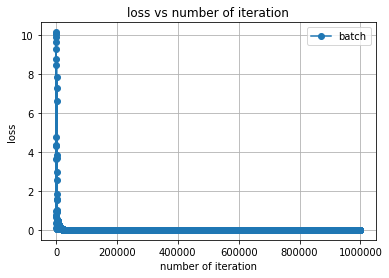

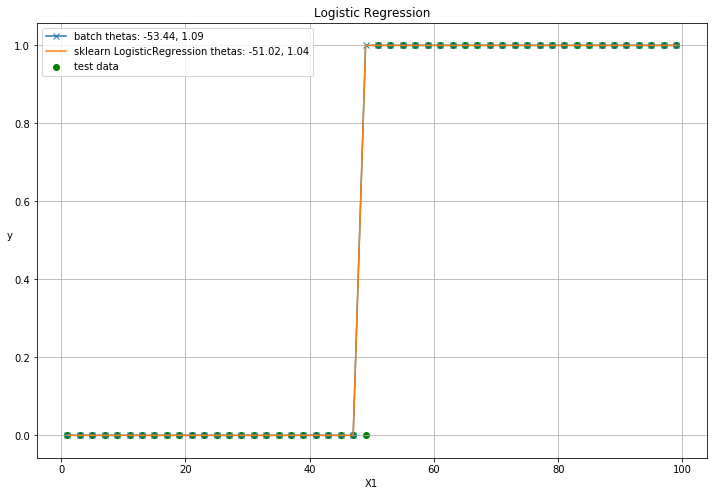

In [3]:
C = Logistic_regression(X1, y, 0.001, 0, 1000000)
thetas, losses, Xs, Zs= C.gradient_descent()

clf = LogisticRegression(C = 1e30)
clf = clf.fit(X1, y.flatten())
m, c = map(np.float, [clf.coef_, clf.intercept_])


# plot loss vs number of iteration for batch and stochastic
plt.figure()
plt.title("loss vs number of iteration")
plt.ylabel("loss")
plt.xlabel("number of iteration")
plt.grid()
plt.plot(list(losses.keys()), list(losses.values()), marker = "o", label = "batch")
plt.legend()
# plot X vs y of the result model
plt.figure()
plt.figure(figsize=(12,8))
#create a different set of Xs, and ys for testing
x_test = np.array([[i,] for i in range(1,101,2)])
y_test  = np.array([0 if i <50 else 1 for i in x_test.flatten()])
plt.scatter(x_test, y_test, color = "g", label = "test data")
plt.plot(x_test.flatten(), C.predict(x_test), label = "batch thetas: " + ", ".join(map(lambda x: str(round(x,2)), thetas.flatten().tolist())), marker = "x")
plt.plot(x_test.flatten(), clf.predict(x_test), label = "sklearn LogisticRegression thetas: "+ ", ".join(map(lambda x: str(round(x,2)), [c,m])))


plt.legend()
plt.grid()
plt.title("Logistic Regression")
plt.ylabel("y").set_rotation(0)
plt.xlabel("X1")

The gradient descent seems to be working pretty well and the weight computed is very similar to each other which is good. What about the accuracy of the predictions?

In [4]:
print ("sklearn accuracy: " + str(clf.score(x_test, y_test)))
print ("self-built accuracy: " + str(C.score(x_test, y_test)))

sklearn accuracy: 0.98
self-built accuracy: 0.98


Lets now consider a bigger dataset with 2 features X1 and X2, and split it up into training and testing sets.

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


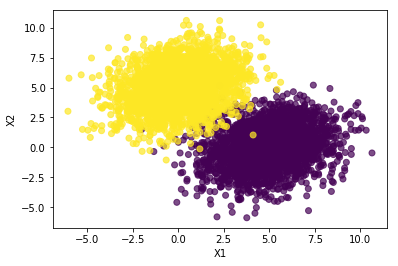

In [5]:
    np.random.seed(12)
    
    X1 = np.random.multivariate_normal([5, 0], [[0.75, 3],[3, 0.75]], 2500)
    X2 = np.random.multivariate_normal([0, 5], [[0.75, 3],[3, 0.75]], 2500)
    X = np.concatenate((X1,X2), axis = 0) 

    y = np.concatenate((np.zeros(2500), np.ones(2500)), axis = 0)  
    
    #plot the data to confirm there is a decision boundary
    plt.figure()
    plt.scatter(np.array([i[0] for i in X]), np.array([i[1] for i in X]), c = y.flatten(), alpha = 0.7)
    plt.xlabel("X1")
    plt.ylabel("X2")   
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state  = 1)

Again, lets's compare the result of the self-built logistic regression with the one in Sk-learn and plot the losses against the number of iteration to confirm that gradient descent is working properly.

weight (Sk-learn):
[-0.36824113] [[-2.12798146  2.29563762]]
weight (self-built):
[[-0.34450898 -2.27546897  2.43491767]]
sklearn accuracy: 0.987
self-built accuracy: 0.987


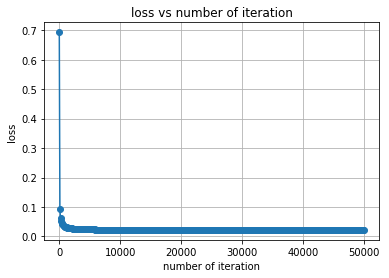

In [6]:
C = Logistic_regression(X_train, y_train, 0.000005, 0, 50000)

thetas, losses, Xs, Zs = C.gradient_descent()

clf = LogisticRegression()
clf = clf.fit(X_train, y_train.flatten())
print ("weight (Sk-learn):")
print (clf.intercept_, clf.coef_)    
print ("weight (self-built):")
print (thetas)

print ("sklearn accuracy: " + str(clf.score(X_test, y_test)))
print ("self-built accuracy: " + str(C.score(X_test, y_test)))    

 # plot loss vs number of iteration for batch and stochastic
plt.figure()
plt.title("loss vs number of iteration")
plt.ylabel("loss")
plt.xlabel("number of iteration")
plt.grid()
plt.plot(list(losses.keys()), list(losses.values()), marker = "o", label = "batch gradient descent")

The results are pretty similar and you can see that the losses converge fairly quickly in this particular use case. Let's plot the predicted label on a graph to better visualise the accuracy. The yellow ones are the incorrect predictions.

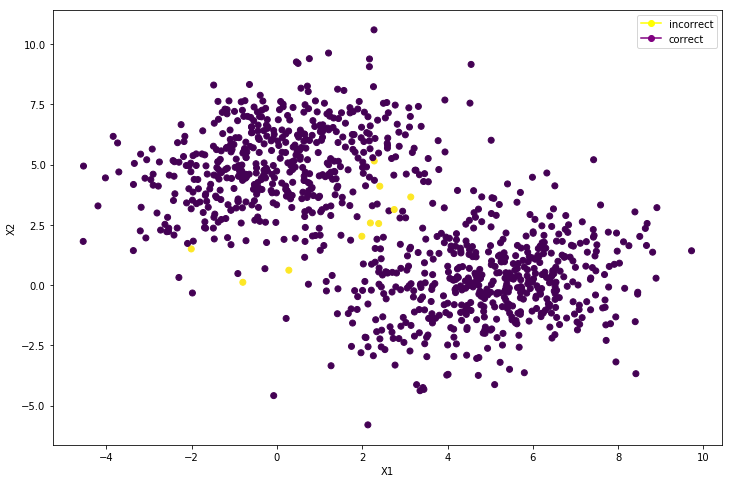

In [7]:
plt.figure()
plt.figure(figsize=(12,8))
ax1 = plt.subplot(111)
ax1.scatter([i[0] for i in X_test],  [i[1] for i in X_test],  c = y_test.flatten() == C.predict(X_test) - 1)
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
circle = plt.Line2D(range(1), range(1), color="yellow", marker='o')
circle1 = plt.Line2D(range(1), range(1), color="purple", marker='o')
ax1.legend([circle,circle1], ["incorrect", "correct"])    

Now let's take a look at stochastic gradient descent and make sure that it's working properly:

thetas:
[-0.09729127 -1.96728838  2.0468582 ]


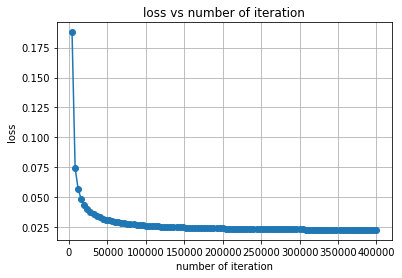

In [25]:
D = Logistic_regression(X_train, y_train, 0.0005, 0, 100)
t, l, xs, zs = D.SGD()
D.score(X_test, y_test)
 # plot loss vs number of iteration for stochastic
plt.figure()
plt.title("loss vs number of iteration")
plt.ylabel("loss")
plt.xlabel("number of iteration")
plt.grid()
plt.plot(list(l.keys()), list(l.values()), marker = "o", label = "batch gradient descent") 
print ("thetas:")
print (t)

Lastly, let's visualise better the route of both batch gradient descent and stochastic gradient descent on a contour map. The contour map indicate the average loss of different theta combination, with the bias kept at constant.

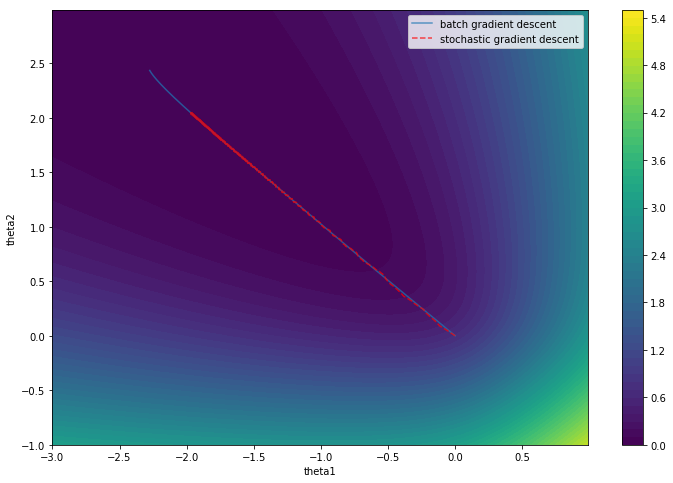

In [28]:
plt.figure(figsize = (12,8))
plt.xlabel("theta1")
plt.ylabel("theta2")
theta1, theta2, J  = C.cost_function(np.arange(-3.0,1.0,0.03), np.arange(-1.0,3.0,0.03))    
ax1 = plt.contourf(theta1, theta2, J.T,  levels = np.arange(0,5.6,0.1).tolist())
plt.colorbar(ax1)
b, x, y = np.hsplit(Xs, 3)
plt.plot(x, y ,alpha = 0.7, label = "batch gradient descent")
b, x, y = np.hsplit(xs, 3)
plt.plot(x[::100], y[::100], linestyle = "--", color = "red", alpha = 0.7, label = "stochastic gradient descent")
plt.legend()

If we take a closer look, we can see that in the beginning stochastic gradient descent already moves a little bit more noisier than batch gradient descent but as it get towards the minimum, its movement becomes much noisier.

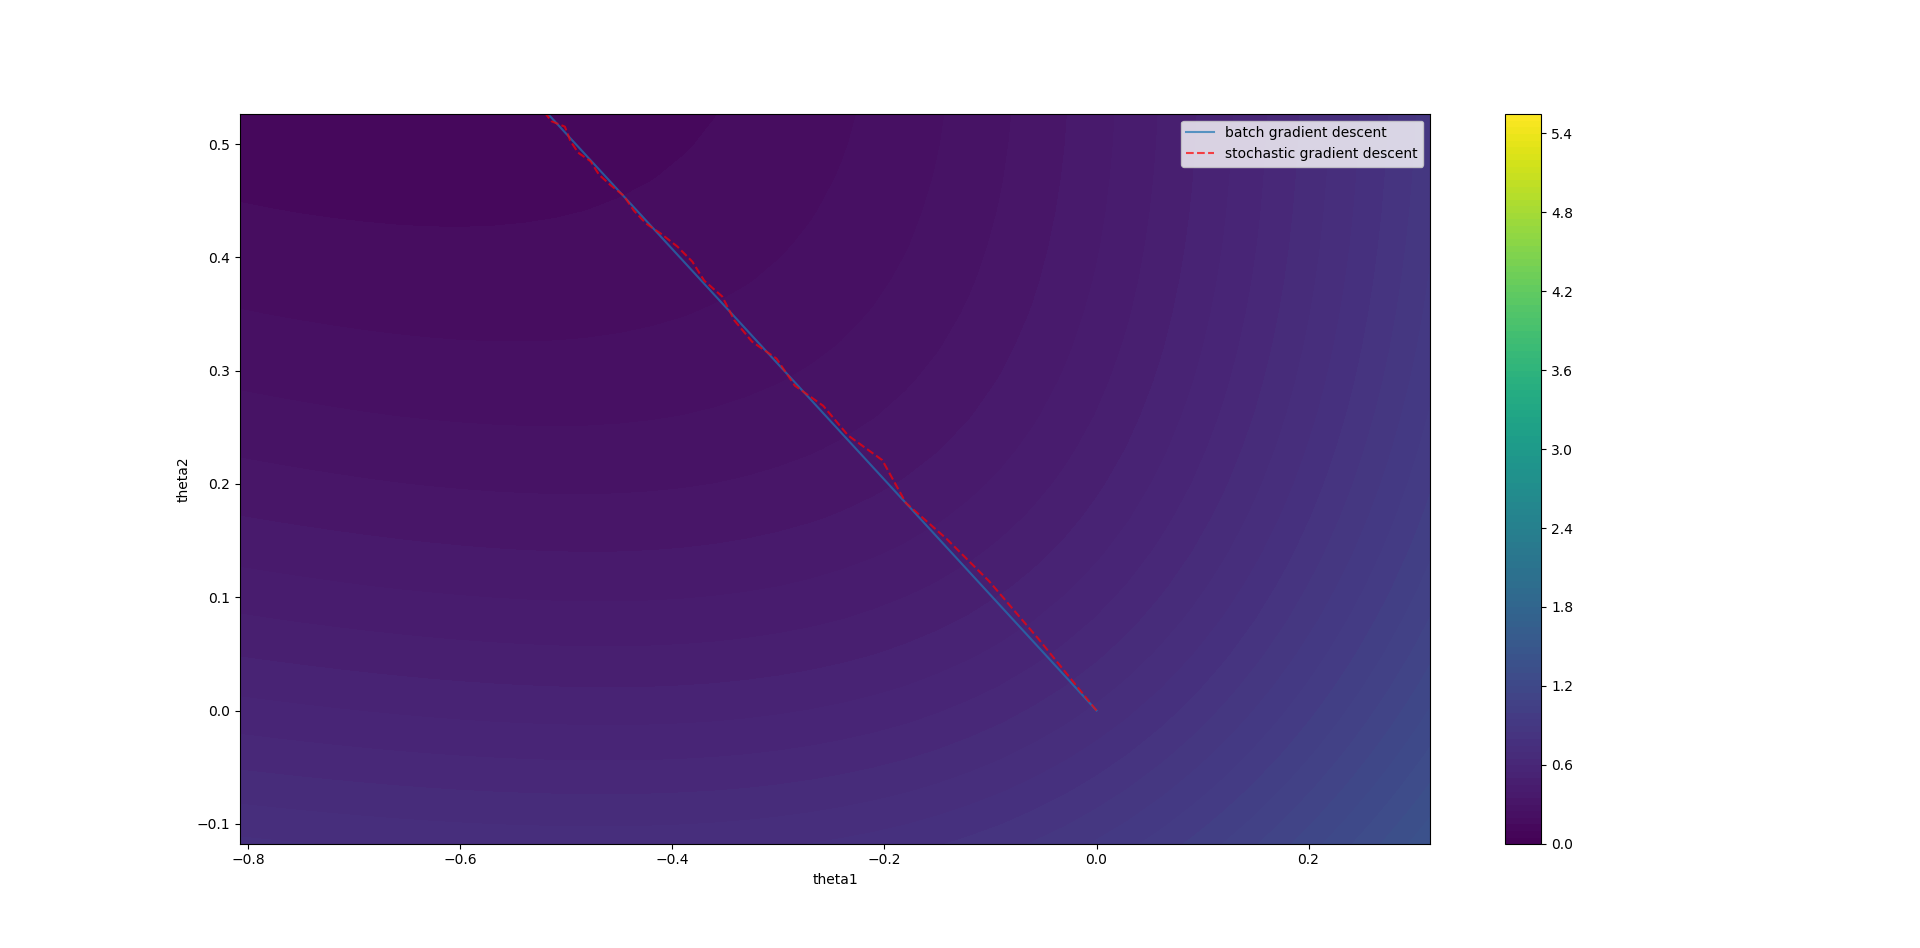

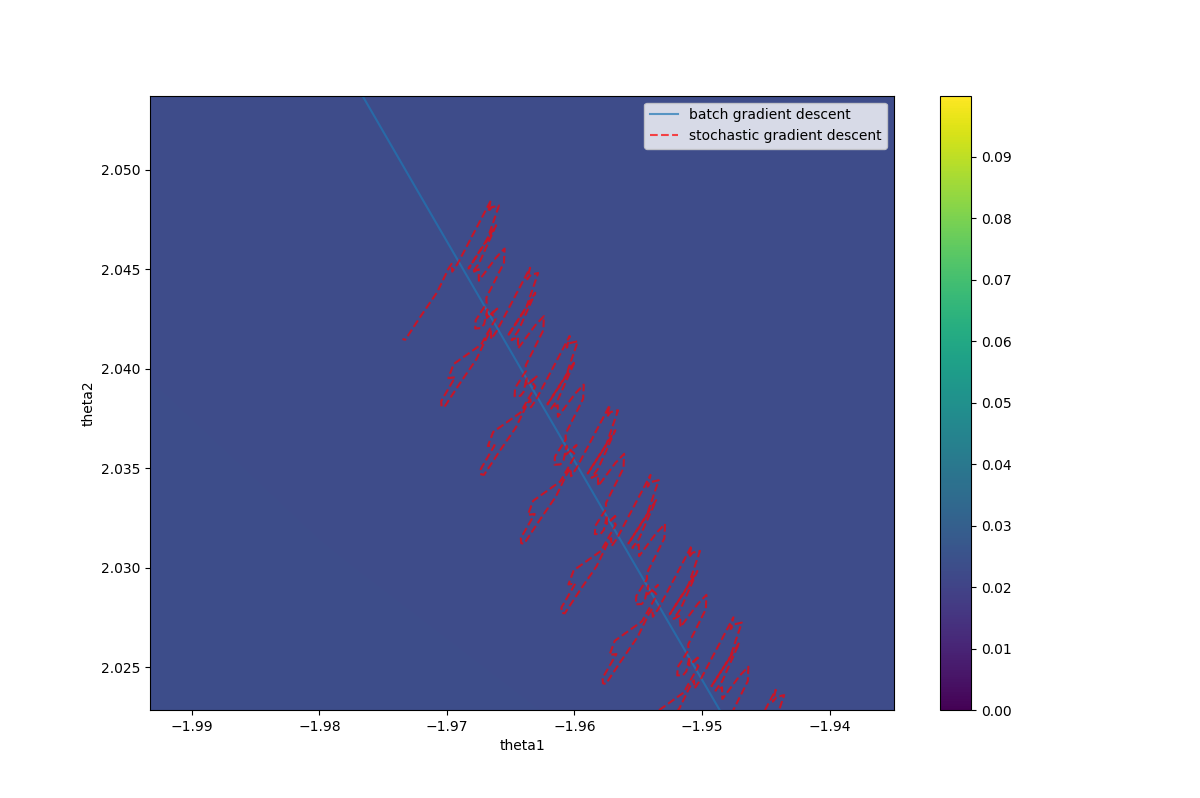

In [5]:
print ("beginning")
display(Image(filename='images\\SGD vs BGD beginning.png', embed=True))
print ("end")
display(Image(filename='images\\SGD vs BGD.png', embed=True))